In [1]:
!pip install bing-image-downloader

Import

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from IPython.display import clear_output

import random
import os
import numpy as np

from bing_image_downloader import downloader

print(f"TensorFlow version: {tf.__version__}")

keywords = ['Aespa Winter', 'Eun-Woo Cha', 'Bruce Lee']
BATCH_SIZE = 64
EPOCH = 5
NUM_IMAGES = 10
num_classes = len(keywords)

TensorFlow version: 2.19.0


데이터 더운받아 리사이즈

In [7]:
def download_and_resize_images(keyword, dpath='./data', num_images=10, output_size=(224,224), verbose=False, with_download=True):
    download_path = dpath

    os.makedirs(download_path, exist_ok=True)
    if with_download:
        downloader.download(
            keyword, limit=num_images,
            output_dir=download_path,
            adult_filter_off=True,
            force_replace=False,
            verbose = verbose,
            timeout=15
        )
    image_folder = os.path.join(download_path, keyword)

    resized_folder = os.path.join(download_path, "resized")
    os.makedirs(resized_folder, exist_ok=True)

    for idx, filename in enumerate(os.listdir(image_folder)):
        try:
            img_path = os.path.join(image_folder, filename)
            img = Image.open(img_path)

            img_resized = img.resize(output_size)
            save_name = f"{keyword}_{idx}.png"
            save_path = os.path.join(resized_folder, save_name)
            img_resized.save(save_path)

        except Exception as e:
            print(f"{filename} Failed: {e}")

    print(f"\n keyword {keyword} Done. resized location: {resized_folder}")

for keyword in keywords:
    clear_output(wait=True)
    download_and_resize_images(keyword, num_images=NUM_IMAGES, with_download=True)

[%] Downloading Images to /content/data/Bruce Lee


[%] Done. Downloaded 10 images.

 keyword Bruce Lee Done. resized location: ./data/resized


데이터 불러오기 및 전처리

In [10]:
def load_all_from_resized(keyword, resized_dir='./data/resized', img_size=(224, 224)):
    images = []
    # 디렉토리 안에 있는 모든 파일 불러오기
    files = os.listdir(resized_dir)
    # 파일명에 keyword가 들어간 파일만 필터링
    filtered_files = [f for f in files if keyword in f]
    for i, fname in enumerate(filtered_files):
        fpath = os.path.join(resized_dir, fname)
        try:
            img = Image.open(fpath).convert('RGB').resize(img_size)
            images.append(np.array(img))
        except Exception as e:
            print(f"{fname} skipped: {e}")

    images = np.array(images)
    return images


x_list, y_list = None, None

for idx, kw in enumerate(keywords):
    imgs = load_all_from_resized(kw, resized_dir='./data/resized')  # img_size=(224, 224) 없엔 이유는?
    labels = np.full(len(imgs), idx)  # 현재 클래스의 레이블 ex) 김치 = 0 , 비빔밥 = 1 , 불고기 = 2

    if x_list is None:
        x_list = imgs
        y_list = labels
    else:
        x_list = np.concatenate((x_list, imgs), axis=0)
        y_list = np.concatenate((y_list, labels), axis=0)

    print(f"{kw}: {len(imgs)} images loaded (label={idx})")

x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.3, random_state=321)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.4, random_state=321)

print(f"\nnum_class :{num_classes}")
print(f"x_train shape : {x_train.shape}, y_train shape : {y_train.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape : {y_test.shape}")
print(f"x_val shape : {x_val.shape}, y_test shape : {y_val.shape}")

def make_generators(x_train, x_test, x_val, y_train, y_test, y_val, batch_size=BATCH_SIZE):
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_gen = train_datagen.flow(x_train, tf.keras.utils.to_categorical(y_train, num_classes=num_classes), batch_size=batch_size)
    test_gen = test_datagen.flow(x_test, tf.keras.utils.to_categorical(y_test, num_classes=num_classes), batch_size=batch_size, shuffle=False)
    val_gen = test_datagen.flow(x_val, tf.keras.utils.to_categorical(y_val, num_classes=num_classes), batch_size=batch_size, shuffle=False)
    return train_gen, test_gen, val_gen

train_gen, test_gen, val_gen = make_generators(x_train, x_test, x_val, y_train, y_test, y_val)


Aespa Winter: 60 images loaded (label=0)
Eun-Woo Cha: 10 images loaded (label=1)
Bruce Lee: 10 images loaded (label=2)

num_class :3
x_train shape : (56, 224, 224, 3), y_train shape : (56,)
x_test shape : (14, 224, 224, 3), y_test shape : (14,)
x_val shape : (10, 224, 224, 3), y_test shape : (10,)


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


모델 구성 및 학습

In [11]:
# 1. 모델 구성
def create_model(num_classes):
    # Pre-trained 모델 로드
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # 동결
    base_model.trainable = False

    # 커스텀 분류기 추가
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model, base_model


# 2. 모델 생성 및 컴파일
model, base_model = create_model(num_classes=num_classes)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. 모델 구조 확인
print(f"- Base model layers: {len(base_model.layers)}")
print(f"- Base model trainable: {base_model.trainable}")
print(f"- parameter: {model.count_params():,}")
print(f"- trainable parameter: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

# 3. 학습 (Stage 1: Feature Extraction)
print("\nStage 1: Feature Extraction")
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCH,
    verbose=1
)

# 4. Fine-tuning (Stage 2)
print("\nStage 2: Fine-tuning")

# 상위 20개 층만 학습 가능하게
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 낮은 학습률로 재컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # 10배 작은 learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"- trainable parameter: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCH,
    verbose=1
)

# 5. 최종 평가
print("\n최종 성능")
test_loss, test_acc = model.evaluate(test_gen)
print(f"테스트 정확도 : {test_acc:.2%}")


- Base model layers: 154
- Base model trainable: False
- parameter: 2,422,339
- trainable parameter: 164,355

Stage 1: Feature Extraction


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3214 - loss: 1.6738 - val_accuracy: 0.8000 - val_loss: 0.7011
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7321 - loss: 1.0118 - val_accuracy: 0.8000 - val_loss: 0.6710
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7143 - loss: 0.8817 - val_accuracy: 0.8000 - val_loss: 0.5853
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7321 - loss: 0.8682 - val_accuracy: 0.8000 - val_loss: 0.5016
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8036 - loss: 0.5372 - val_accuracy: 0.9000 - val_loss: 0.3991

Stage 2: Fine-tuning
- trainable parameter: 1,370,435
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.8214 - loss: 0.5879 - val_accuracy: 0.9000 - val_loss: 0.3968
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7321 - loss: 0.6695 - val_accuracy: 0.9000 - val_loss: 0.3941
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7500 - loss: 0.6451 - val_a

학습 과정 시각화

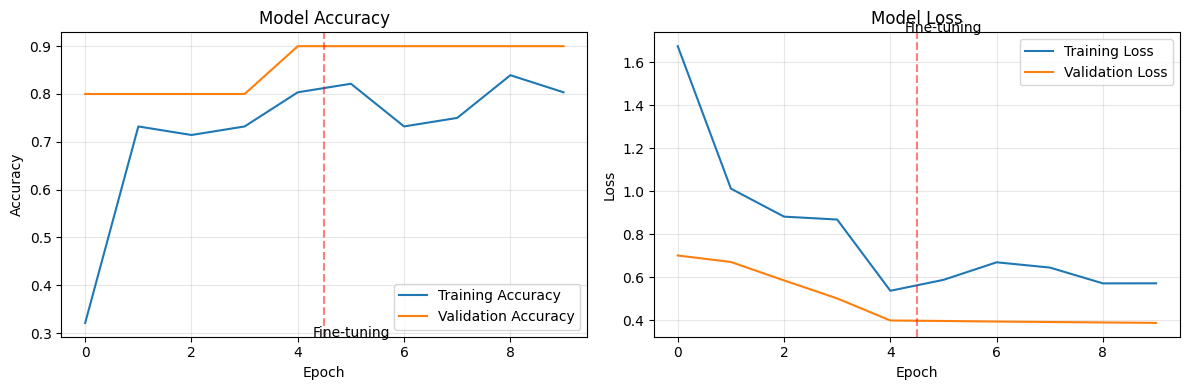

In [12]:
# 6. 학습 과정 시각화
def plot_training_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.axvline(x=EPOCH-0.5, color='r', linestyle='--', alpha=0.5)
    plt.text(EPOCH, plt.ylim()[0], 'Fine-tuning', ha='center')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.axvline(x=EPOCH-0.5, color='r', linestyle='--', alpha=0.5)
    plt.text(EPOCH, plt.ylim()[1], 'Fine-tuning', ha='center')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history1, history2)


예측 결과 보기

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


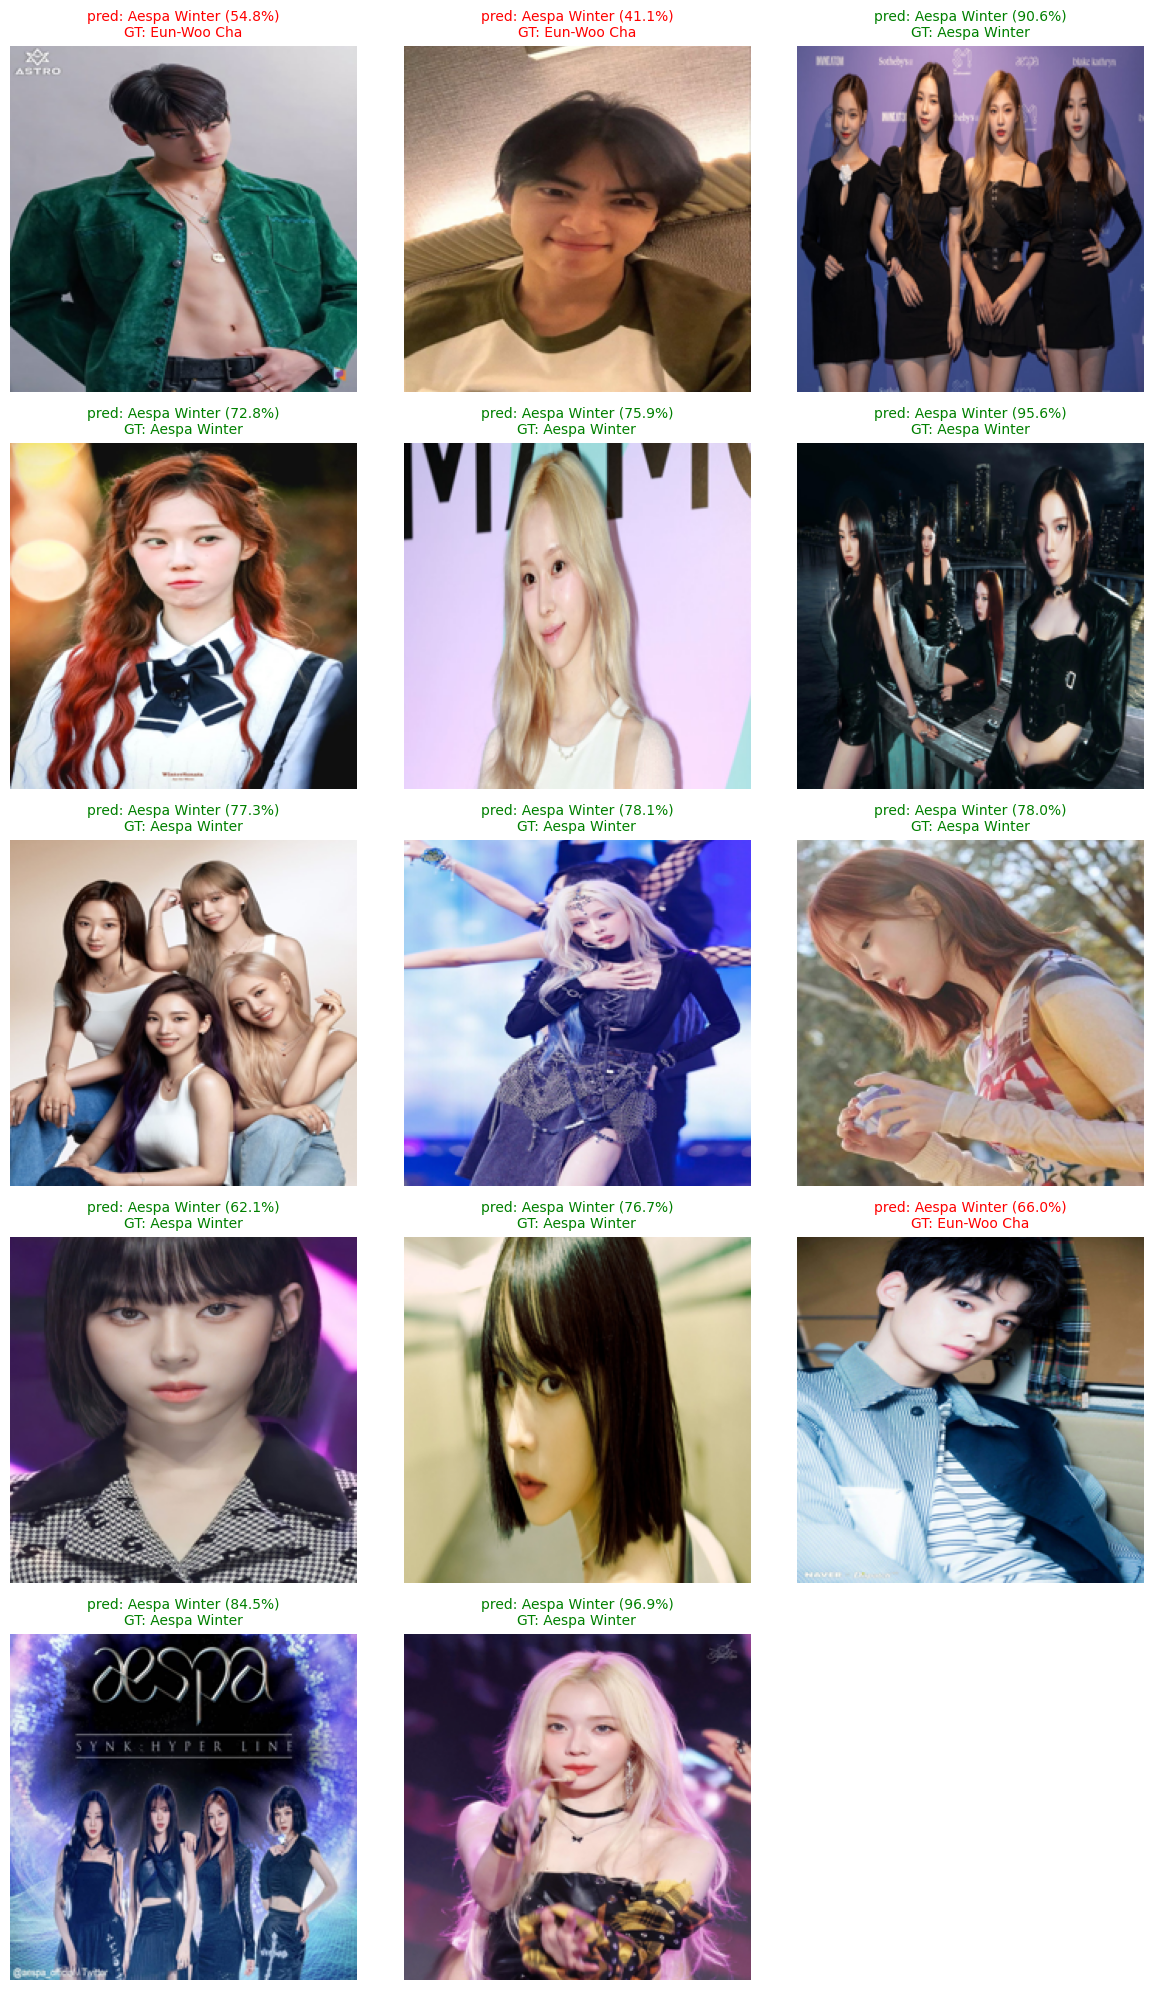

model saved : 'my_transfer_learning_model.h5'


In [14]:
# 7. 예측 결과 보기
def show_predictions(generator, model, class_names, num_images=6):
    images, labels = next(generator)

    # Determine the actual number of images to display
    actual_num_images_to_display = min(num_images, len(images))

    # If there are no images, return early
    if actual_num_images_to_display == 0:
        print("No images to display.")
        return

    # Calculate rand_idx ensuring a valid range
    # If actual_num_images_to_display == len(images), this makes randint(0, 0), which is 0.
    if len(images) > actual_num_images_to_display:
        rand_idx = random.randint(0, len(images) - actual_num_images_to_display)
    else:
        rand_idx = 0 # Start from 0 if we are displaying all available images

    labels = labels[rand_idx:rand_idx + actual_num_images_to_display]
    images = images[rand_idx:rand_idx + actual_num_images_to_display]

    predictions = model.predict(images)

    # Adjust figure size based on the actual number of images displayed
    rows = (actual_num_images_to_display + 2) // 3 # Ensure enough rows for all images
    plt.figure(figsize=(12, 4 * rows))
    for i in range(actual_num_images_to_display):
        plt.subplot(rows, 3, i + 1)

        # 이미지 역정규화 (보기가 좋게)
        img = images[i] * 127.5 + 127.5
        plt.imshow(img.astype('uint8'))

        # 예측 결과
        pred_class = np.argmax(predictions[i])
        confidence = predictions[i][pred_class]
        actual_class = np.argmax(labels[i])

        # 제목 색상 (맞으면 초록, 틀리면 빨강)
        color = 'green' if pred_class == actual_class else 'red'

        plt.title(f'pred: {class_names[pred_class]} ({confidence:.1%})\n' # Use actual_num_images_to_display
                  f'GT: {class_names[actual_class]}',
                  color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


show_predictions(test_gen, model, keywords, 18)

# 8. 모델 저장
model.save('my_transfer_learning_model.h5')
print("model saved : 'my_transfer_learning_model.h5'")